In [8]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import basename
from glob import glob

%matplotlib inline

from matplotlib.colors import Normalize, ListedColormap

from load_from_raw import adjust_contrast
from evaluate import get_mask_from_gt, visualise

In [15]:
test_paths = glob(
    "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test/images/*"
)
test_full_images = set(basename(img_path).split("_")[0] for img_path in test_paths)

test_paths = glob(
    "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test/images/*"
)
test_patches_images = list(
    set(basename(img_path).split("_")[0] for img_path in test_paths)
)

list(test_full_images.intersection(test_patches_images))

['010-0896', '009-9703', '007-0137', '007-0258']

In [16]:
N_ROWS_PATCH = 8
N_COLS_PATCH = 8

PATH_DATASET_PATCH_IMAGES = (
    "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test/images"
)
PATH_DATASET_FULL_IMAGES = (
    "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test/images"
)
PATH_DATASET_SINGLE = "../data/data_labeled/ctrst-0-255_srfc-0_prcs-0_seg"
#PATH_DATASET_FULL_IMAGES = "../image_test/test/images"
#PATH_DATASET_PATCH_IMAGES = "../image_test_patch/test/images"

PATH_MODEL_FULL = "../models/full/best.pt"
PATH_MODEL_PATCH = "../models/patches/best.pt"
PATH_SINGLE_MODEL = "../runs/segmentation/yolo11n_ctrst-0-255_srfc-0_prcs_0_seg_single_model_epochs-100_imgsz-1616_batch-8/weights/best.pt"

img_name = "008-2980"

In [4]:
img_name = "009-9752"

In [5]:
interactive_plot, img_mask, img, combined_slices, combined_images, big_model_img_mask, small_model_img_mask = visualise(
    img_name,
    True,
    PATH_DATASET_PATCH_IMAGES,
    PATH_DATASET_FULL_IMAGES,
    PATH_MODEL_FULL,
    PATH_MODEL_PATCH,
    True,
    N_ROWS_PATCH,
    N_COLS_PATCH,
)

101it [03:35,  2.13s/it]
100%|██████████| 118/118 [01:19<00:00,  1.49it/s]


In [6]:
interactive_plot

interactive(children=(IntSlider(value=0, description='Slice:'), IntSlider(value=0, description='Min Contrast:'…

In [8]:
viridis_cmap = plt.cm.viridis
new_colors = viridis_cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]
custom_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=1, vmax=101)

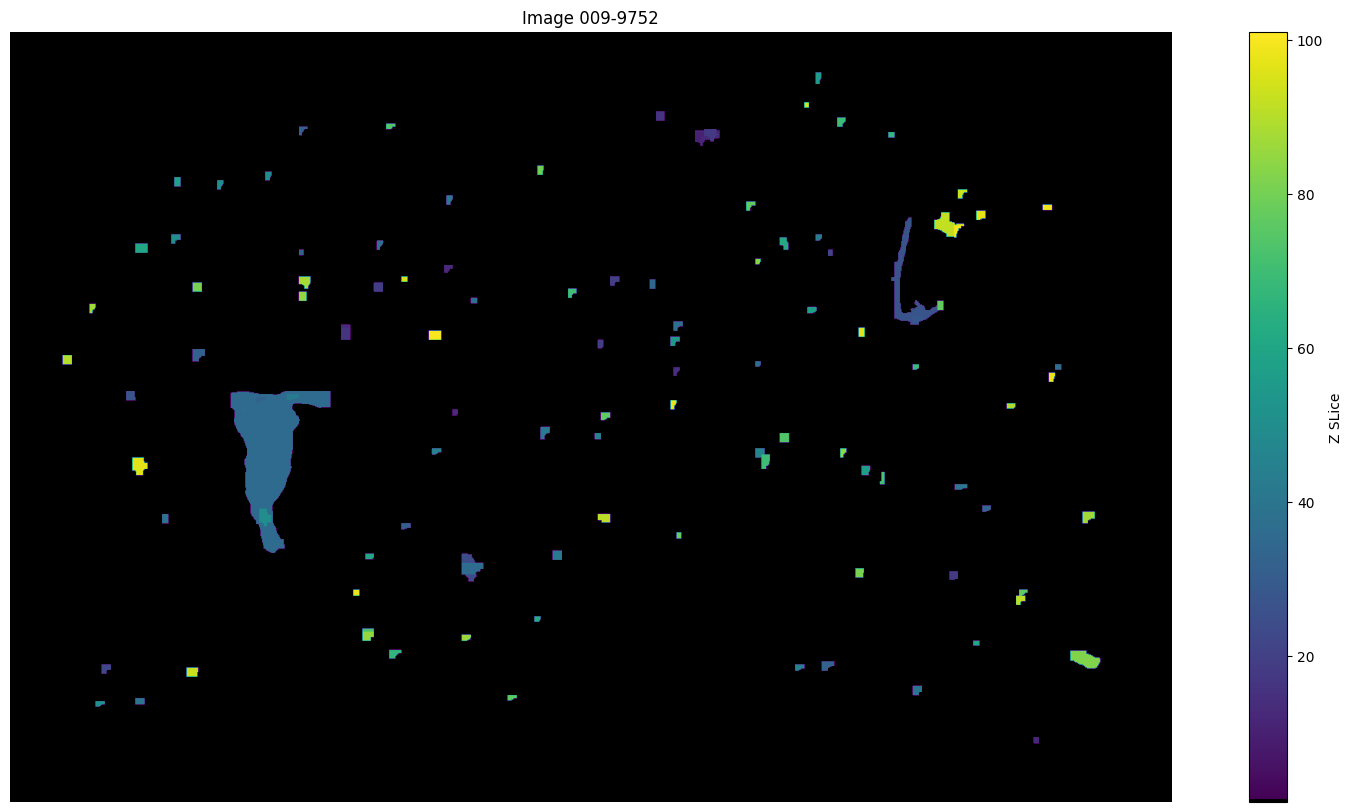

In [11]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name}")
plt.imshow(combined_slices, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

In [ ]:
from load_from_raw import adjust_contrast

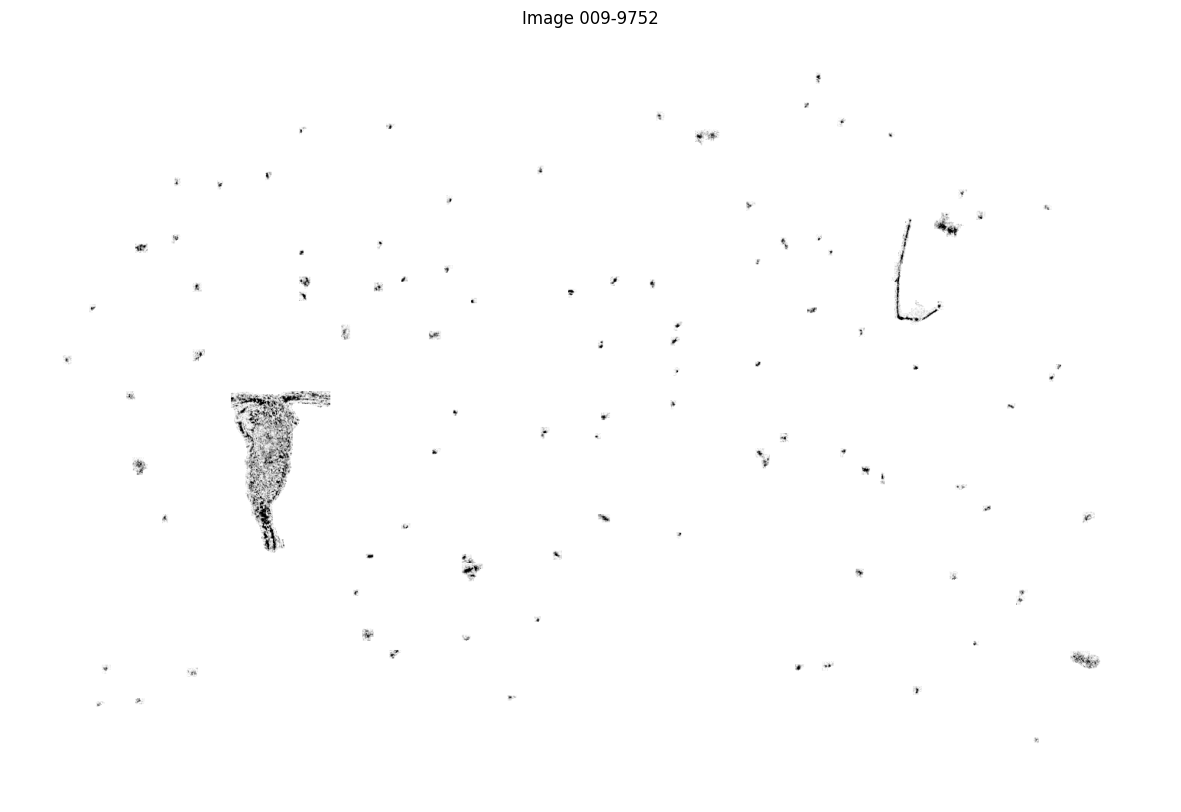

In [13]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name}")
plt.imshow(adjust_contrast(combined_images,210,255), cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

______

## Validation

Try computing dice by first concatenating ground truth and prediction arrays, find connected components that are spanning across 2 slices (find corresponding predictions) and compute the dice on those

In [17]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from os.path import join, basename, dirname, exists
from scipy.ndimage import label
import matplotlib.pyplot as plt
import tifffile as tiff
from evaluate import evaluate_final_output

In [18]:
TEST_FOLDER_PATH_SMALL = (
    "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test"
)
TEST_FOLDER_PATH_BIG = "../data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test"

labeled_folder_path = "../data/data_labeled/ctrst-0-255_srfc-200_prcs-0_seg"

images_small = set(
    [
        basename(file_path).split("_")[0]
        for file_path in glob(join(TEST_FOLDER_PATH_SMALL, "images", "*.jpg"))
    ]
)
images_big = set(
    [
        basename(file_path).split("_")[0]
        for file_path in glob(join(TEST_FOLDER_PATH_BIG, "images", "*.jpg"))
    ]
)

images = list(images_small.union(images_big))

In [19]:
images

['007-0258', '007-0137', '010-0896', '009-9703']

In [20]:
test_tp_old = 0
test_fp_old = 0
test_fn_old = 0
best_dices_old = []
best_dices_non_zero_old = []
sizes_old = []
sizes_nonzero_old = []
test_tp_single = 0
test_fp_single = 0
test_fn_single = 0
best_dices_single = []
best_dices_non_zero_single = []
sizes_single = []
sizes_nonzero_single = []
test_tp_new = 0
test_fp_new = 0
test_fn_new = 0
best_dices_new = []
best_dices_non_zero_new = []
sizes_new = []
sizes_nonzero_new = []

# Iterate through the images of the test set
for img_name in images:
    # Get the mask from the ground truth
    mask_gt = get_mask_from_gt(labeled_folder_path, img_name)
    # Get the mask from the original model
    img_stack = tiff.imread(f"../dep_files/{img_name}-dep.tiff")
    gray_image = cv2.cvtColor(img_stack, cv2.COLOR_BGR2GRAY)
    cropped_gray_image = gray_image[95:-167, 39:-57]
    _, mask_previous_model = cv2.threshold(
        cropped_gray_image.astype(np.uint8),
        0,
        255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )
    # Get the mask from the combined model
    _, _, _, combined_slices, combined_images = visualise(
        img_name,
        True,
        PATH_DATASET_PATCH_IMAGES,
        PATH_DATASET_FULL_IMAGES,
        PATH_MODEL_FULL,
        PATH_MODEL_PATCH,
        True,
        8,
        8,
    )
    # Get the mask from the single model
    _, _, _, combined_slices_single_model, _ = visualise(
        img_name, True, None, PATH_DATASET_SINGLE, PATH_SINGLE_MODEL, None, False
    )

    # Evaluate the original model's mask
    perf_dict_old = evaluate_final_output(mask_gt, mask_previous_model)
    test_tp_old += perf_dict_old["true_positive"]
    test_fp_old += perf_dict_old["false_positive"]
    test_fn_old += perf_dict_old["false_negative"]
    best_dices_old += perf_dict_old["best_dices"]
    best_dices_non_zero_old += perf_dict_old["best_dices_non_zero"]
    sizes_old += perf_dict_old["sizes"]
    sizes_nonzero_old += perf_dict_old["sizes_nonzero"]

    # Evaluate the single model's mask
    perf_dict_single = evaluate_final_output(
        mask_gt, combined_slices_single_model[95:-137, 39:-57]
    )
    test_tp_single += perf_dict_single["true_positive"]
    test_fp_single += perf_dict_single["false_positive"]
    test_fn_single += perf_dict_single["false_negative"]
    best_dices_single += perf_dict_single["best_dices"]
    best_dices_non_zero_single += perf_dict_single["best_dices_non_zero"]
    sizes_single += perf_dict_single["sizes"]
    sizes_nonzero_single += perf_dict_single["sizes_nonzero"]

    # Evaluate the combined model's mask
    perf_dict_new = evaluate_final_output(mask_gt, np.where(combined_slices > 0, 1, 0))
    test_tp_new += perf_dict_new["true_positive"]
    test_fp_new += perf_dict_new["false_positive"]
    test_fn_new += perf_dict_new["false_negative"]
    best_dices_new += perf_dict_new["best_dices"]
    best_dices_non_zero_new += perf_dict_new["best_dices_non_zero"]
    sizes_new += perf_dict_new["sizes"]
    sizes_nonzero_new += perf_dict_new["sizes_nonzero"]

    # Output the performances of each model for the current image
    print(f"For image {img_name}:")
    for key in perf_dict_new.keys():
        if key not in ["best_dices", "best_dices_non_zero", "sizes", "sizes_nonzero"]:
            print(
                f"{key} : {round(perf_dict_old[key],2)} for old model, {round(perf_dict_single[key],2)} for single model, {round(perf_dict_new[key],2)} for combined model"
            )
    print("")
# Compute the final performances on the test set
test_recall_old = test_tp_old / (test_tp_old + test_fn_old)
test_precision_old = test_tp_old / (test_tp_old + test_fp_old)
test_f1_score_old = (
    2 * test_recall_old * test_precision_old / (test_recall_old + test_precision_old)
)
test_mDice_old = np.mean(best_dices_old)
test_mDice_non_zero_old = np.mean(best_dices_non_zero_old)
test_weighted_mDice_old = np.sum(
    [sizes_old[i] * best_dices_old[i] for i in range(len(sizes_old))]
) / np.sum(sizes_old)
test_weighted_mDice_non_zero_old = np.sum(
    [
        sizes_nonzero_old[i] * best_dices_non_zero_old[i]
        for i in range(len(best_dices_non_zero_old))
    ]
) / np.sum(sizes_nonzero_old)

test_recall_single = test_tp_single / (test_tp_single + test_fn_single)
test_precision_single = test_tp_single / (test_tp_single + test_fp_single)
test_f1_score_single = (
    2
    * test_recall_single
    * test_precision_single
    / (test_recall_single + test_precision_single)
)
test_mDice_single = np.mean(best_dices_single)
test_mDice_non_zero_single = np.mean(best_dices_non_zero_single)
test_weighted_mDice_single = np.sum(
    [sizes_single[i] * best_dices_single[i] for i in range(len(sizes_single))]
) / np.sum(sizes_single)
test_weighted_mDice_non_zero_single = np.sum(
    [
        sizes_nonzero_single[i] * best_dices_non_zero_single[i]
        for i in range(len(best_dices_non_zero_single))
    ]
) / np.sum(sizes_nonzero_single)

test_recall_new = test_tp_new / (test_tp_new + test_fn_new)
test_precision_new = test_tp_new / (test_tp_new + test_fp_new)
test_f1_score_new = (
    2 * test_recall_new * test_precision_new / (test_recall_new + test_precision_new)
)
test_mDice_new = np.mean(best_dices_new)
test_mDice_non_zero_new = np.mean(best_dices_non_zero_new)
test_weighted_mDice_new = np.sum(
    [sizes_new[i] * best_dices_new[i] for i in range(len(sizes_new))]
) / np.sum(sizes_new)
test_weighted_mDice_non_zero_new = np.sum(
    [
        sizes_nonzero_new[i] * best_dices_non_zero_new[i]
        for i in range(len(best_dices_non_zero_new))
    ]
) / np.sum(sizes_nonzero_new)

# Output the final performances on the test set
print("On test set:")
print(
    f"True Positives : {round(test_tp_old,2)} for old model, {round(test_tp_single,2)} for single model and {round(test_tp_new,2)} for combined model"
)
print(
    f"False Positives : {round(test_fp_old,2)} for old model, {round(test_fp_single,2)} for single model and {round(test_fp_new,2)} for combined model"
)
print(
    f"False Negatives : {round(test_fn_old,2)} for old model, {round(test_fn_single,2)} for single model and {round(test_fn_new,2)} for combined model"
)
print(
    f"Recall : {round(test_recall_old,2)} for old model, {round(test_recall_single,2)} for single model and {round(test_recall_new,2)} for combined model"
)
print(
    f"Precision : {round(test_precision_old,2)} for old model, {round(test_precision_single,2)} for single model and {round(test_precision_new,2)} for combined model"
)
print(
    f"F1-Score : {round(test_f1_score_old,2)} for old model, {round(test_f1_score_single,2)} for single model and {round(test_f1_score_new,2)} for combined model"
)
print(
    f"mDice : {round(test_mDice_old,2)} for old model, {round(test_mDice_single,2)} for single model and {round(test_mDice_new,2)} for combined model"
)
print(
    f"mDice_nonzero : {round(test_mDice_non_zero_old,2)} for old model, {round(test_mDice_non_zero_single,2)} for single model and {round(test_mDice_non_zero_new,2)} for combined model"
)
print(
    f"weighted_mDice : {round(test_weighted_mDice_old,2)} for old model, {round(test_weighted_mDice_single,2)} for single model and {round(test_weighted_mDice_new,2)} for combined model"
)
print(
    f"weighted_mDice_nonzero : {round(test_weighted_mDice_non_zero_old,2)} for old model, {round(test_weighted_mDice_non_zero_single,2)} for single model and {round(test_weighted_mDice_non_zero_new,2)} for combined model"
)

101it [03:34,  2.12s/it]
100%|██████████| 252/252 [02:50<00:00,  1.48it/s]


101it [00:44,  2.25it/s]
100%|██████████| 51/51 [00:45<00:00,  1.12it/s]


For image 007-0258:
true_positive : 25 for old model, 23 for single model, 28 for combined model
false_positive : 33 for old model, 27 for single model, 169 for combined model
false_negative : 3 for old model, 5 for single model, 0 for combined model
recall : 0.89 for old model, 0.82 for single model, 1.0 for combined model
precision : 0.43 for old model, 0.46 for single model, 0.14 for combined model
f1-score : 0.58 for old model, 0.59 for single model, 0.25 for combined model
mDice : 0.49 for old model, 0.65 for single model, 0.75 for combined model
nonzero_mDice : 0.54 for old model, 0.79 for single model, 0.75 for combined model
weighted_mDice : 0.53 for old model, 0.71 for single model, 0.78 for combined model
nonzero_weighted_mDice : 0.57 for old model, 0.82 for single model, 0.78 for combined model



101it [03:33,  2.12s/it]
100%|██████████| 259/259 [02:58<00:00,  1.45it/s]


101it [00:43,  2.31it/s]
100%|██████████| 60/60 [00:52<00:00,  1.13it/s]


For image 007-0137:
true_positive : 11 for old model, 17 for single model, 17 for combined model
false_positive : 60 for old model, 43 for single model, 202 for combined model
false_negative : 6 for old model, 0 for single model, 0 for combined model
recall : 0.65 for old model, 1.0 for single model, 1.0 for combined model
precision : 0.15 for old model, 0.28 for single model, 0.08 for combined model
f1-score : 0.25 for old model, 0.44 for single model, 0.14 for combined model
mDice : 0.39 for old model, 0.8 for single model, 0.74 for combined model
nonzero_mDice : 0.6 for old model, 0.8 for single model, 0.74 for combined model
weighted_mDice : 0.42 for old model, 0.83 for single model, 0.79 for combined model
nonzero_weighted_mDice : 0.66 for old model, 0.83 for single model, 0.79 for combined model



101it [03:31,  2.10s/it]
100%|██████████| 371/371 [04:09<00:00,  1.48it/s]


101it [00:44,  2.26it/s]
100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


For image 010-0896:
true_positive : 8 for old model, 10 for single model, 10 for combined model
false_positive : 103 for old model, 46 for single model, 264 for combined model
false_negative : 2 for old model, 0 for single model, 0 for combined model
recall : 0.8 for old model, 1.0 for single model, 1.0 for combined model
precision : 0.07 for old model, 0.18 for single model, 0.04 for combined model
f1-score : 0.13 for old model, 0.3 for single model, 0.07 for combined model
mDice : 0.6 for old model, 0.83 for single model, 0.78 for combined model
nonzero_mDice : 0.75 for old model, 0.83 for single model, 0.78 for combined model
weighted_mDice : 0.66 for old model, 0.85 for single model, 0.81 for combined model
nonzero_weighted_mDice : 0.74 for old model, 0.85 for single model, 0.81 for combined model



101it [03:34,  2.13s/it]
100%|██████████| 315/315 [03:32<00:00,  1.48it/s]


101it [00:44,  2.25it/s]
100%|██████████| 36/36 [00:32<00:00,  1.11it/s]


For image 009-9703:
true_positive : 11 for old model, 10 for single model, 15 for combined model
false_positive : 791 for old model, 23 for single model, 206 for combined model
false_negative : 4 for old model, 5 for single model, 0 for combined model
recall : 0.73 for old model, 0.67 for single model, 1.0 for combined model
precision : 0.01 for old model, 0.3 for single model, 0.07 for combined model
f1-score : 0.03 for old model, 0.42 for single model, 0.13 for combined model
mDice : 0.44 for old model, 0.52 for single model, 0.72 for combined model
nonzero_mDice : 0.59 for old model, 0.78 for single model, 0.72 for combined model
weighted_mDice : 0.46 for old model, 0.54 for single model, 0.74 for combined model
nonzero_weighted_mDice : 0.6 for old model, 0.78 for single model, 0.74 for combined model

On test set:
True Positives : 55 for old model, 60 for single model and 70 for combined model
False Positives : 987 for old model, 139 for single model and 841 for combined model
Fals

In [117]:
viridis_cmap = plt.cm.viridis
new_colors = viridis_cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]
custom_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=1, vmax=101)

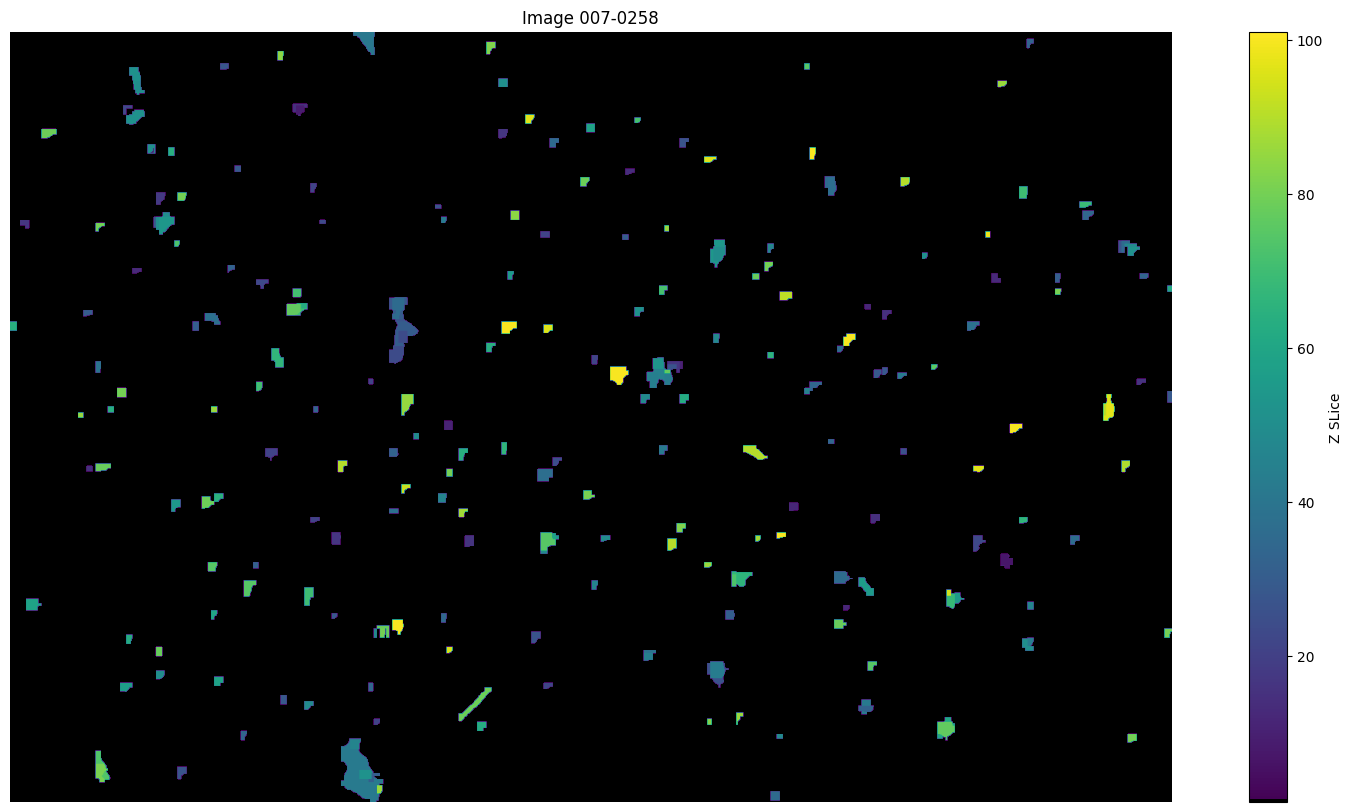

In [119]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name} | Combined Model's Masks")
plt.imshow(combined_slices, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

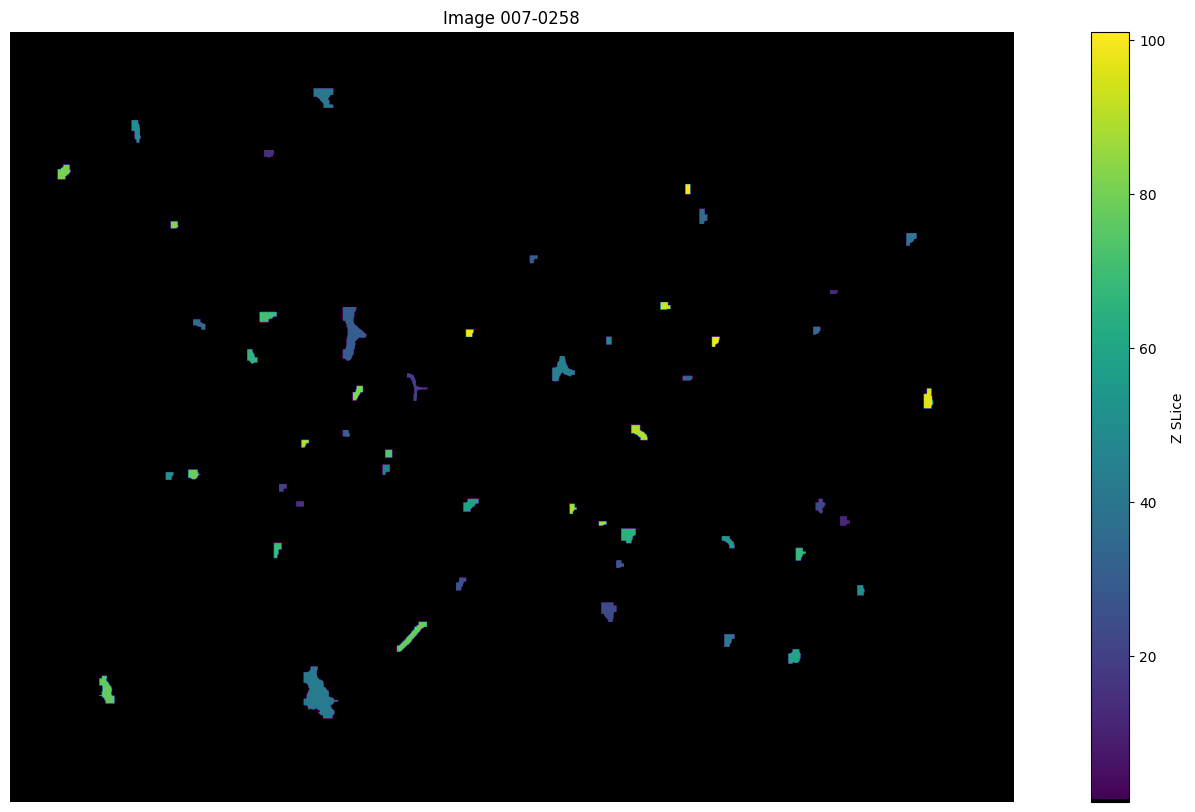

In [120]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name} | Single Model's Masks")
plt.imshow(combined_slices_single_model, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

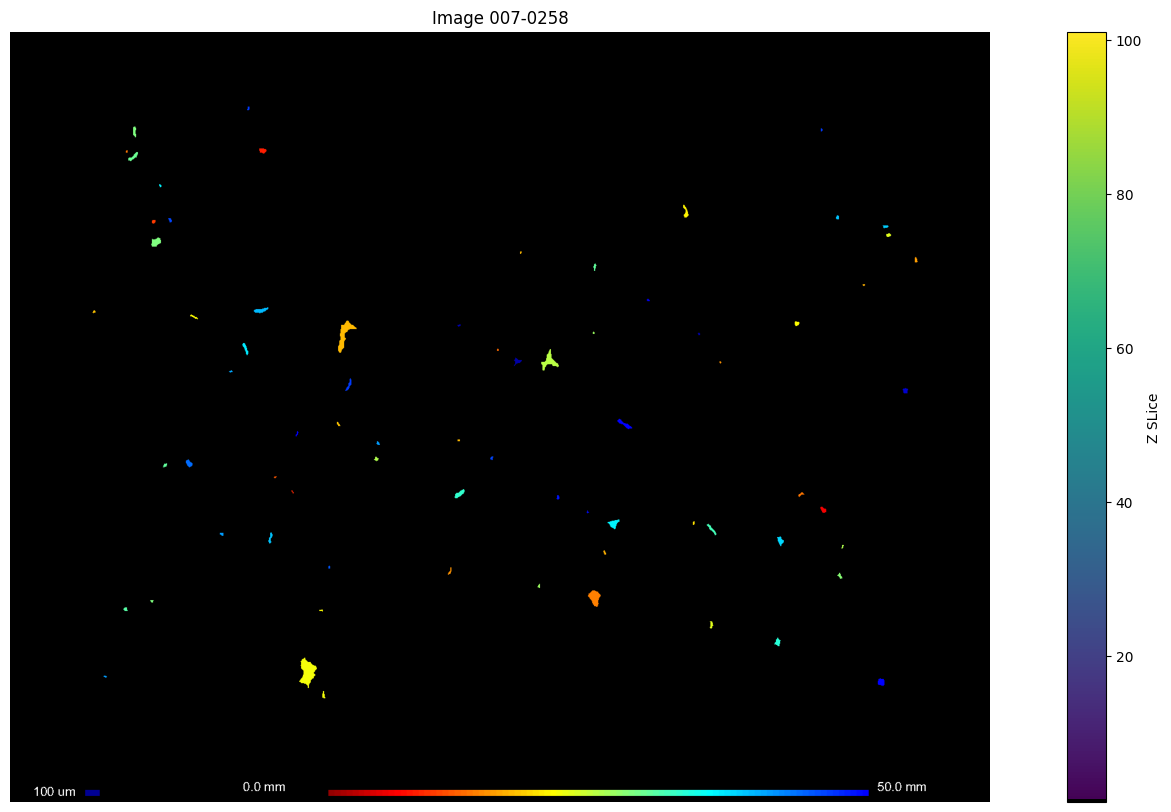

In [121]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name} | Original Model's Masks")
plt.imshow(img_stack, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

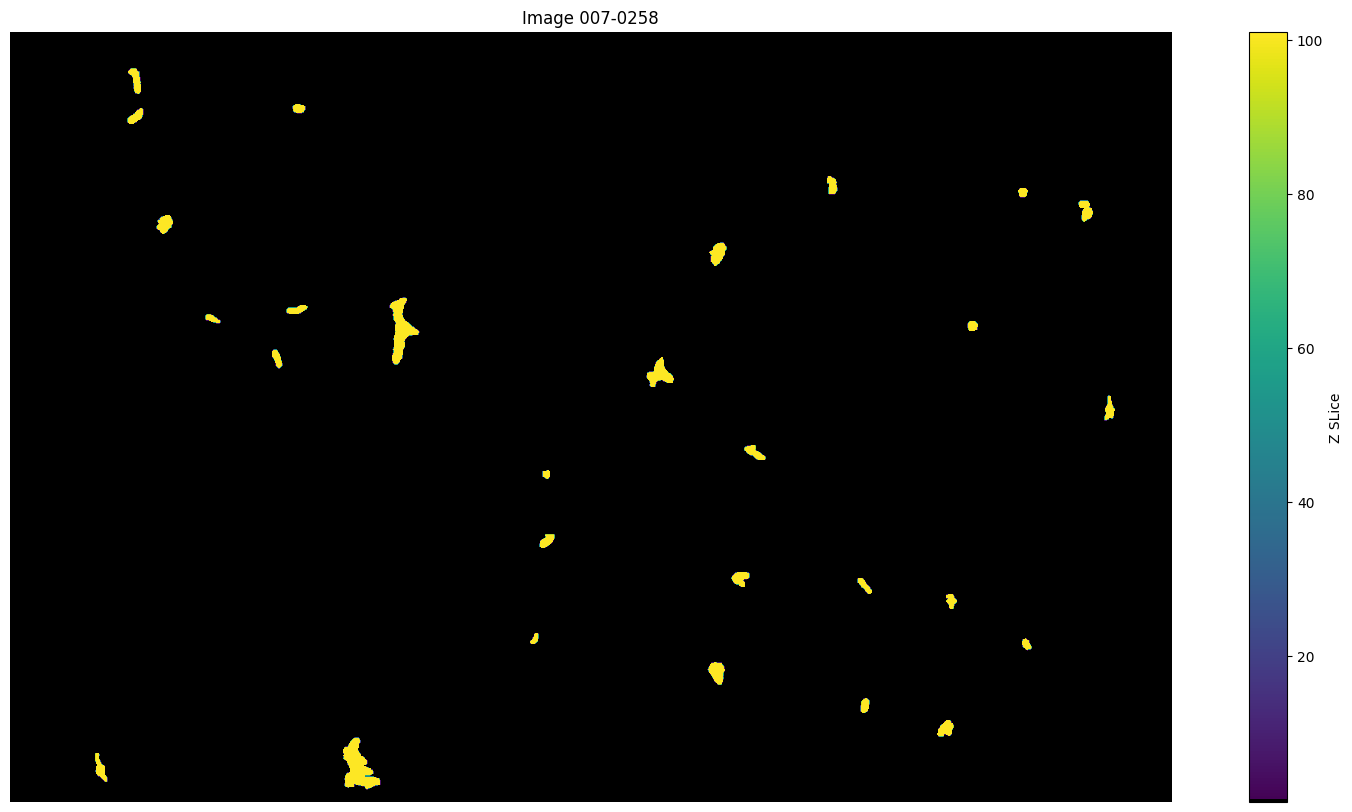

In [122]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name} | Original Label")
plt.imshow(mask_gt, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

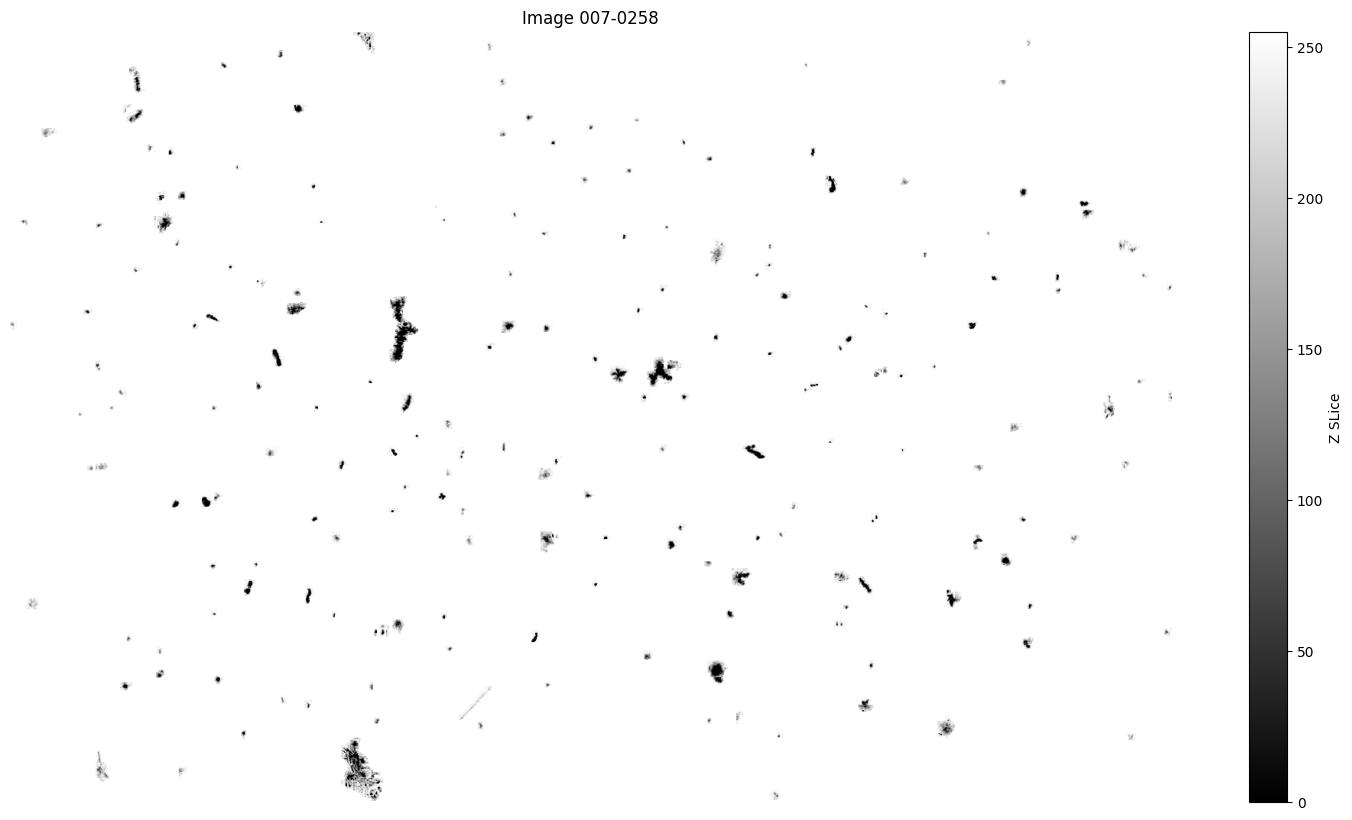

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f"Image {img_name} | Combined Model's Segmented Image")
plt.imshow(adjust_contrast(combined_images, 210, 255), cmap="gray")
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()